# Basic loading, visualising images and labels

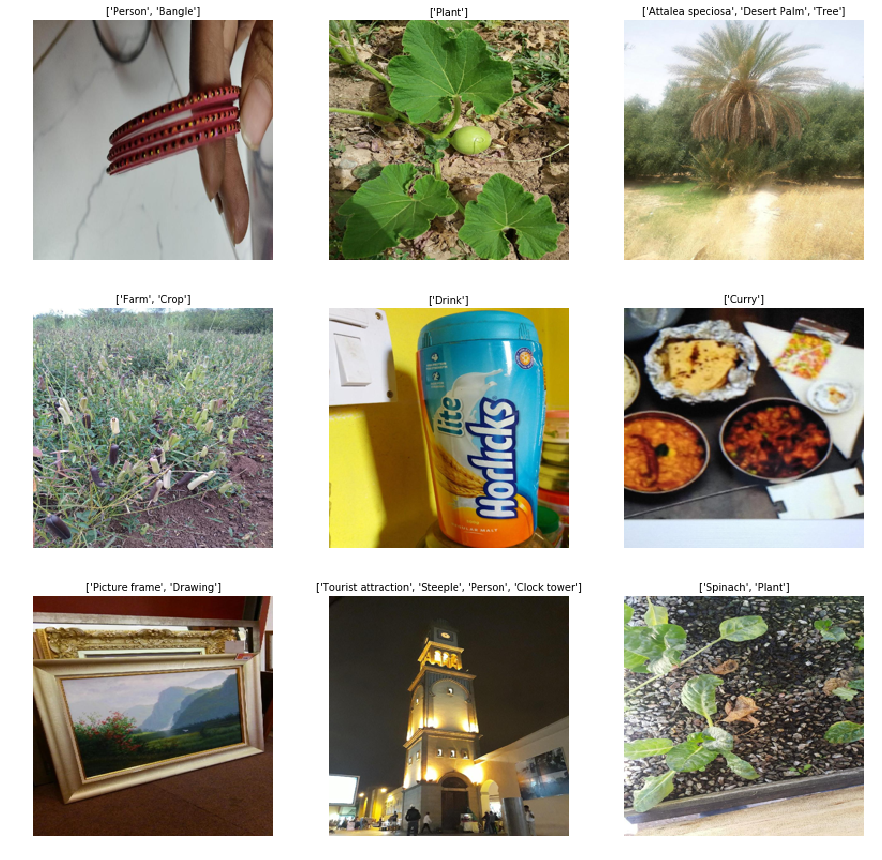

In [3]:
"""Explore the data, plot training and test example images."""


import os, glob, random
import csv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np



# data_path = '/Users/amritk/Desktop/workspace/staging/inc_images'
data_path = '/Users/amritk/Desktop/inc_images'


def read_csv(file_path):
    """Read csv file."""
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        out_list = list(reader)
        return out_list


def get_class_map_dict():
    """Read the class descriptions to a dict."""
    class_map = {}
    file_path = os.path.join(data_path, 'misc', 'class-descriptions.csv')
    contents = read_csv(file_path)
    for idx, item in enumerate(contents):
        if item[0][0] == '/':
            class_map[item[0]] = item[1]
    return class_map


def read_tuning_labels_stage_1():
    """Read the labels proved for tuning for stage-1."""
    tuning_labels = {}
    file_path = os.path.join(data_path, 'misc', 'tuning_labels.csv')
    contents = read_csv(file_path)
    for idx, item in enumerate(contents):
        image_id = item[0]
        labels = item[1].split(' ')
        tuning_labels[image_id] = labels
    return tuning_labels


def read_train_human_labels():
    """Read the training labels annotated by humans."""
    human_train_labels = {}
    file_path = os.path.join(data_path, 'misc', 'train_human_labels.csv')
    contents = read_csv(file_path)
    class_map = get_class_map_dict()
    for item in contents:
        image_id = item[0]
        source = item[1]
        label_code = item[2]
        confidence = item[3]
        if label_code in class_map:
            if not human_train_labels.get(image_id):
                human_train_labels[image_id] = {'labels': [], 'confidences': []}
            else:
                human_train_labels[image_id]['labels'].append(class_map[label_code])
                human_train_labels[image_id]['confidences'].append(confidence)
    return human_train_labels
    
    
def read_train_machine_labels():
    """Read the training labels annotated by machines."""
    machine_train_labels = {}
    file_path = os.path.join(data_path, 'misc', 'train_machine_labels.csv')
    contents = read_csv(file_path)
    class_map = get_class_map_dict()
    for item in contents:
        image_id = item[0]
        source = item[1]
        label_code = item[2]
        confidence = item[3]
        if label_code in class_map:
            if not machine_train_labels.get(image_id):
                machine_train_labels[image_id] = {'labels': [], 'confidences': []}
            else:
                machine_train_labels[image_id]['labels'].append(class_map[label_code])
                machine_train_labels[image_id]['confidences'].append(confidence)
    return machine_train_labels


def get_test_image_list():
    """Get list of paths to test images."""
    images_path = os.path.join(data_path, 'misc', 'stage_1_test_images')
    images = glob.glob(os.path.join(images_path, '*.jpg'))
    return images


def plot_example_test_images(labels, class_map, n_images=9, crop=False):
    """Plot example test images"""
    indices = np.arange(len(labels))
    random.shuffle(indices)
    images_inds_random = indices[0:n_images]
    images_random = list(labels.keys())
    images_random = [images_random[idx] for idx in images_inds_random]
    images_path = os.path.join(data_path, 'misc', 'stage_1_test_images')
    fig, ax = plt.subplots()
    ax.set_axis_off()
    fig.set_size_inches((15,15))
    idx = 0
    for image_name in images_random:
        label = labels[image_name]
        for i, _ in enumerate(label):
            label[i] = class_map[label[i]]
        a = fig.add_subplot(3, 3, idx + 1)
        image_path = os.path.join(images_path, image_name + '.jpg')
        img = Image.open(image_path)
        if crop:
            img = img.resize((224, 224), resample=Image.BICUBIC)
        img = np.array(img)
        
        plt.title(label, fontsize=10)
        plt.axis('off')
        plt.imshow(img)
        idx += 1
        
        
def get_train_image_list(folder_name):
    """Get list of paths to train images (just 1 folder)."""
    images_path = os.path.join(data_path, 'train_images', folder_name)
    images = glob.glob(os.path.join(images_path, '*.jpg'))
    return images


def read_trainable_classes():
    """Read file with trainable classes"""
    file_path = os.path.join(data_path, 'misc', 'classes-trainable.csv')
    contents = read_csv(file_path)
    class_map_dict = get_class_map_dict()
    trainable_classes = {}
    for item in contents:
        label_code = item[0]
        if label_code in class_map_dict:
            trainable_classes[label_code] = class_map_dict[label_code]
    return trainable_classes
         
            
def explore_test_data_stage_1():
    """Plot some example stage-1 test images with labels"""
    class_map = get_class_map_dict()
    tuning_labels = read_tuning_labels_stage_1()
    test_image_list = get_test_image_list()
    plot_example_test_images(tuning_labels, class_map, crop=True)
    
    
def get_n_most_frequent_classes(n_classes):
    """Get most frequent classes from the tuning set."""
    # test_labels = read_train_human_labels()
    test_labels = read_tuning_labels_stage_1()
    labels_freq = {}
    for key, item in test_labels.items():
        # for label in item['labels']:
        for label in item:
            if not label in labels_freq:
                labels_freq[label] = 0
            else:
                labels_freq[label] += 1
    label_ids = list(labels_freq.keys())
    label_freqs = list(labels_freq.values())
    label_ids = list(reversed([x for _, x in sorted(zip(label_freqs, label_ids))]))
    freqs = list(reversed(sorted(label_freqs)))
    class_map = get_class_map_dict()
    for idx, lab in enumerate(label_ids):
        label_ids[idx] = class_map[lab]
    return label_ids[0:n_classes], freqs[0:n_classes]


explore_test_data_stage_1()

# Load a prediction file for Stage-1 testset and perform error analysis

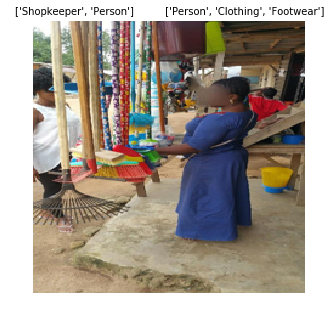

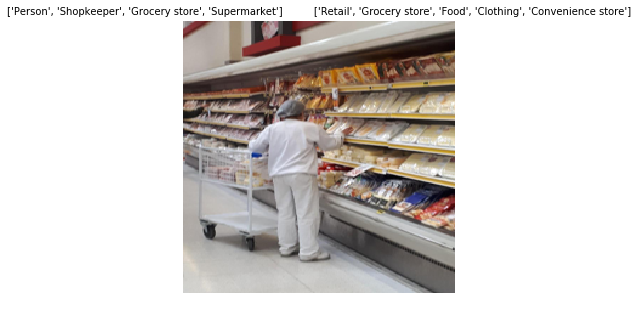

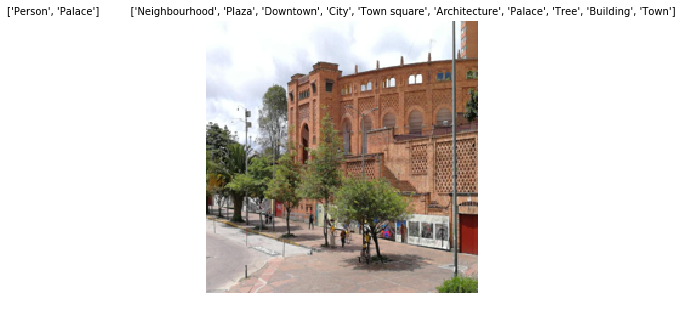

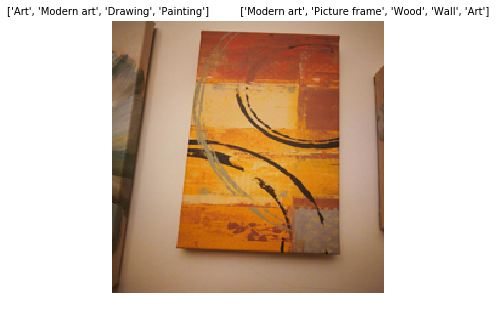

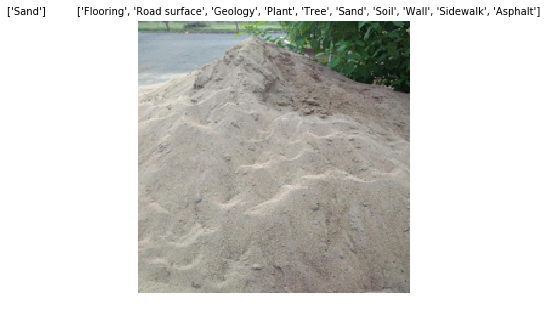

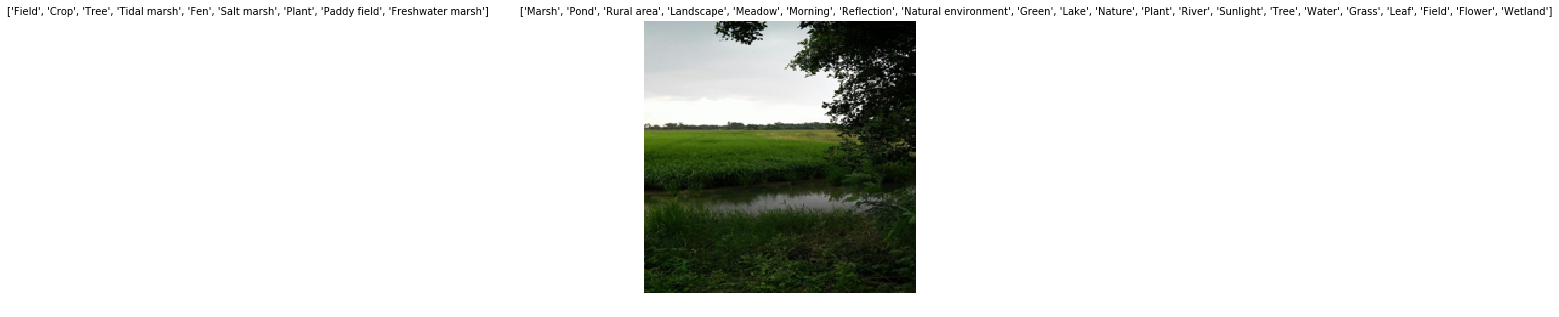

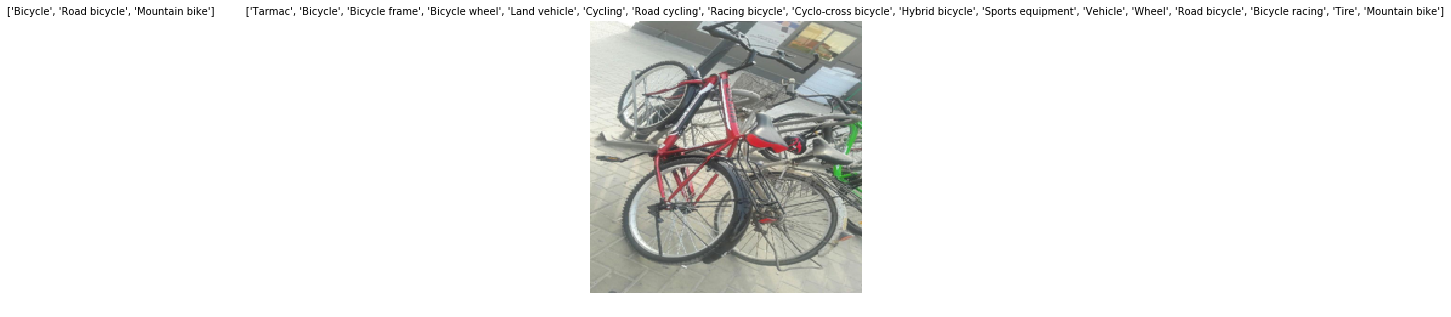

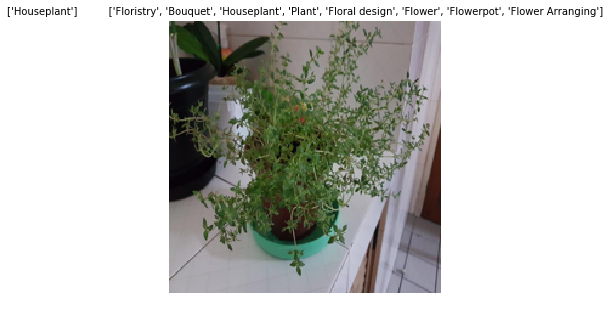

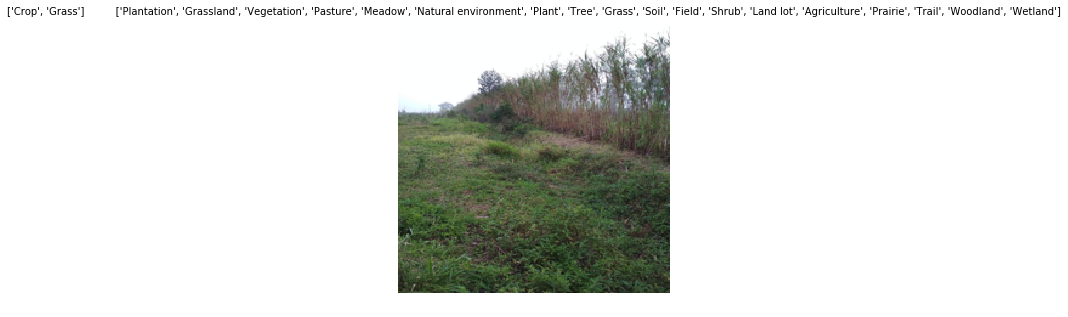

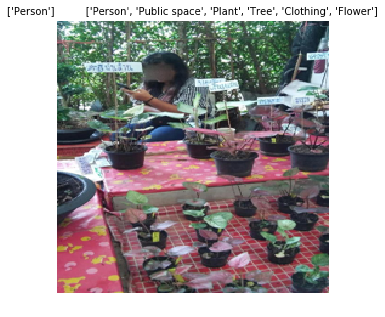

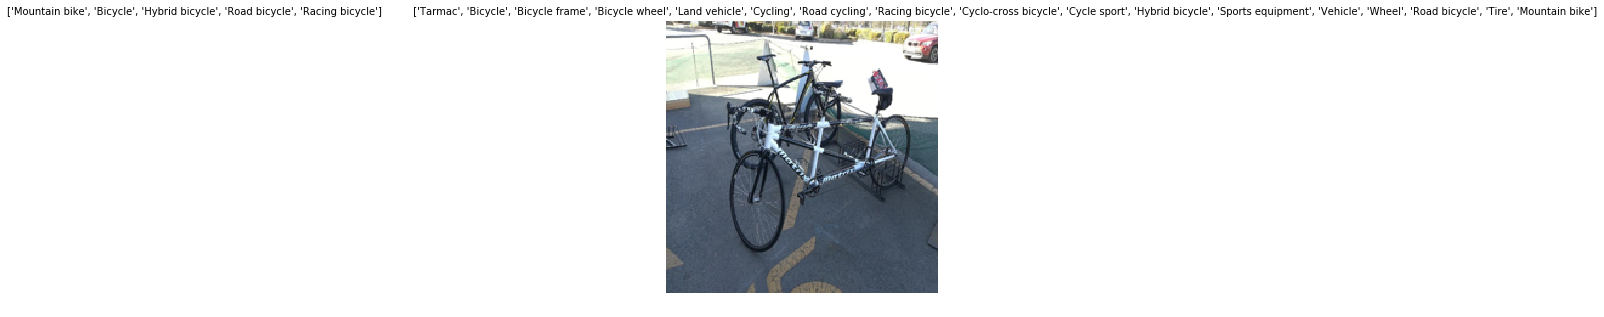

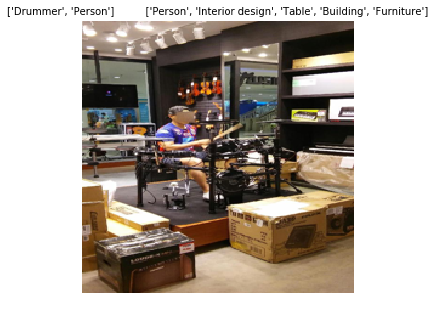

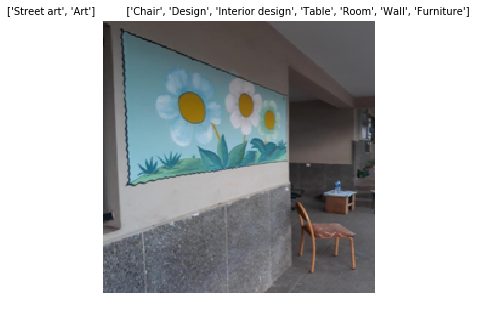

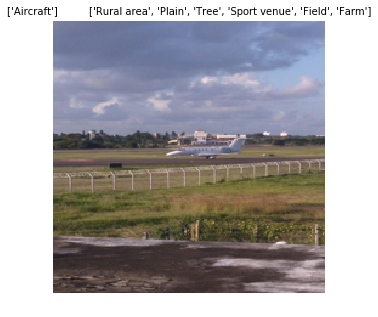

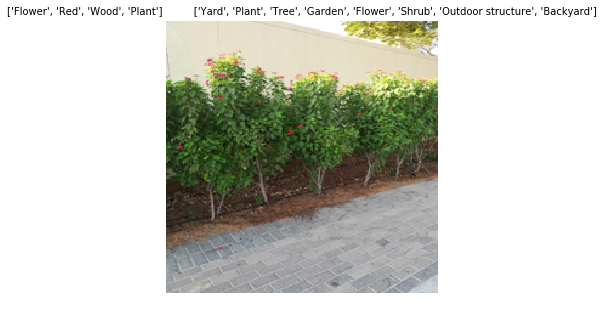

In [37]:
prediction_file = 'submission/submission_error_analysis.csv'
images_path = os.path.join(data_path, 'misc', 'stage_1_test_images')
predicted_labels = read_csv(prediction_file)
del predicted_labels[0] # remove header
predicted_labels_dict = {}
for image_id, lab in predicted_labels:
    predicted_labels_dict[image_id] = lab
tuning_labels = read_tuning_labels_stage_1()

class_map = get_class_map_dict()

def analyse_image(image_id):
    gt = tuning_labels[image_id]
    pred = predicted_labels_dict[image_id]
    pred = pred.split(' ')
    fig, ax = plt.subplots()
    ax.set_axis_off()
    fig.set_size_inches((5, 5))
    for i, _ in enumerate(pred):
        pred[i] = class_map[pred[i]]
    for i, _ in enumerate(gt):
        gt[i] = class_map[gt[i]]
    image_path = os.path.join(images_path, image_id + '.jpg')
    img = Image.open(image_path)
    img = img.resize((224, 224), resample=Image.BICUBIC)
    img = np.array(img)
    plt.title(str(gt) + '          ' + str(pred), fontsize=10)
    plt.axis('off')
    plt.imshow(img)
        

count = 0
for image_id, _ in tuning_labels.items():
    analyse_image(image_id)
    count += 1
    if count == 15:
        break
    
